# Reinforcement Learning

# Bandit algorithms

This notebook presents **multi-armed bandit** algorithms.

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from classes.model import Environment
from classes.agent import Agent

## Multi-Armed Bandit

Multi-armed bandits are single-state models with random rewards.

In [2]:
class MAB(Environment):
    """Multi-Armed Bandit environnement.
    
    Parameters
    ----------
    distribution: string
        Reward distribution (Bernoulli, Uniform or Gaussian)
    params: list
        List of parameters (one per action)
        Example for Bernoulli (prob): [0.4, 0.5, 0.6]
        Example for Uniform (low, high): [(-1, 1), (0, 1), (-1, 2)]
        Example for Gaussian (mean, variance): [(0, 1), (1, 2), (-1, 1)]
    """

    def __init__(self, distribution='bernoulli', params=[0.4, 0.6]):        
        if type(distribution) != str:
            raise ValueError('The distribution parameter must be a string: either Bernoulli, uniform or Gaussian.')
        self.distribution = distribution.lower()
        self.params = params
         
    @staticmethod
    def get_states():
        """Single state."""
        return [None]
    
    def get_actions(self):
        """One action per arm."""
        actions = [action for action, _ in enumerate(self.params)]
        return actions
    
    def get_reward(self, action):
        """Random reward. The parameter depends on the action."""
        if self.distribution == 'bernoulli':
            return np.random.random() < self.params[action]
        if self.distribution == 'uniform':
            low, high = self.params[action]
            return np.random.uniform(low, high)
        if self.distribution in ['gaussian', 'normal']:
            mean, std = self.params[action]
            return np.random.normal(mean, std)
        raise ValueError('Unknown distribution.')
        
    def get_model(self):
        raise ValueError('Not available.')
        
    def step(self, action):
        stop = False
        reward = self.get_reward(action)
        return reward, stop

In [3]:
class Bandit(Agent):
    """Bandit algorithm with random policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, init_value=0, init_count=0):
        if not isinstance(model, MAB):
            raise ValueError('The model must be a multi-armed bandit.')
        self.model = model
        self.policy = self.random_policy
        actions = model.get_actions()
        self.values = len(actions) * [init_value]
        self.counts = len(actions) * [init_count]

    def get_actions(self, state=None):
        """Get all possible actions."""
        return self.model.get_actions()
    
    def get_episode(self, n_steps=100):
        """Get the rewards for an episode and update the values."""
        state = None
        rewards = []
        for t in range(n_steps):
            action = self.get_action(state)
            reward, _ = self.model.step(action)
            rewards.append(reward)
            self.counts[action] += 1
            diff = reward - self.values[action]
            # update by temporal difference
            self.values[action] += diff / self.counts[action]
        return rewards    

In [4]:
model = MAB()
model.distribution

'bernoulli'

In [5]:
model.params

[0.4, 0.6]

In [6]:
agent = Bandit(model)
agent.get_actions()

[0, 1]

In [7]:
rewards = agent.get_episode(n_steps=1000)
np.mean(rewards)

0.485

In [8]:
agent.values

[0.3469387755102041, 0.617647058823529]

In [9]:
agent.counts

[490, 510]

## The $\varepsilon$-greedy policy

In [10]:
class Greedy(Bandit):
    """Bandit algorithm with eps-greedy policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    eps : float in [0, 1]
        Exploration rate.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, eps=0.1, init_value=0, init_count=0):
        super(Greedy, self).__init__(model, init_value, init_count) 
        self.eps = eps

    def get_action(self, state=None):
        """Get action with eps-greedy policy."""
        actions = self.get_actions()
        if np.random.random() > self.eps:
            # select the best action(s) with probability 1 - eps
            values = np.array(self.values)
            actions = np.flatnonzero(values==np.max(values))
        return np.random.choice(actions)


In [11]:
agent = Greedy(model)
rewards = agent.get_episode(n_steps=1000)
np.mean(rewards)

0.588

In [12]:
agent.values

[0.3859649122807018, 0.6002120890774117]

In [13]:
agent.counts

[57, 943]

In [14]:
agent = Greedy(model, eps=0.2)
rewards_list = []
num_episodes = 10
for _ in range(num_episodes):
    rewards_list.append(np.mean(agent.get_episode(n_steps=100000)))
    print(agent.values)
np.mean(rewards_list)

[0.40122723673792376, 0.6014283171664943]
[0.3994669825288703, 0.6010748979069485]
[0.4012400646416657, 0.6004286577746145]
[0.4030287984111223, 0.600314133214725]
[0.4017548048227284, 0.6006430410594751]
[0.40132747033933486, 0.6007059019704099]
[0.4015420354297583, 0.6002416513583666]
[0.40143534697953004, 0.6004681335777965]
[0.40104426485749406, 0.6002311701879233]
[0.4015012377225919, 0.6004383118326286]


0.580508

In [15]:
agent = Greedy(model, eps=0, init_value=0, init_count=0)
rewards = agent.get_episode(n_steps=1000)
print('Mean reward:', np.mean(rewards))
print('Values:', agent.values)
print('Counts:', agent.counts)

Mean reward: 0.6
Values: [0.0, 0.601202404809619]
Counts: [2, 998]


In [16]:
agent = Greedy(model, eps=0, init_value=1, init_count=1)
rewards = agent.get_episode(n_steps=1000)
print('Mean reward:', np.mean(rewards))
print('Values:', agent.values)
print('Counts:', agent.counts)

Mean reward: 0.609
Values: [0.5555555555555556, 0.610271903323263]
Counts: [9, 993]


## The UCB policy

We now consider the UCB (Upper Confidence Bound) policy.

In [17]:
class UCB(Bandit):
    """Bandit algorithm with UCB policy. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    const : float in [0, 1]
        Multiplicative constant for the UCB bonus.
    init_value : float
        Initial value of the action-value function.
    init_count : int
        Initial count of the action-count function.
    """
    
    def __init__(self, model, const=1, init_value=0, init_count=0):
        super(UCB, self).__init__(model, init_value, init_count) 
        self.const = const

    def get_action(self, state=None):
        """Get action with UCB policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        """if np.any(counts == 0):
            return np.flatnonzero(counts == 0)[0]        
        actions = self.get_actions()
        ucb = values + self.const * np.sqrt(np.log(np.sum(counts)) / counts)
        return np.argmax(ucb)"""
        if np.min(counts) == 0:
            actions = np.flatnonzero(counts == 0)
        else:
            ucb = values + self.const * np.sqrt(np.log(np.sum(counts)) / counts)
            actions = np.flatnonzero(ucb == np.max(ucb))
        return np.random.choice(actions)


### Bernoulli-distributed rewards

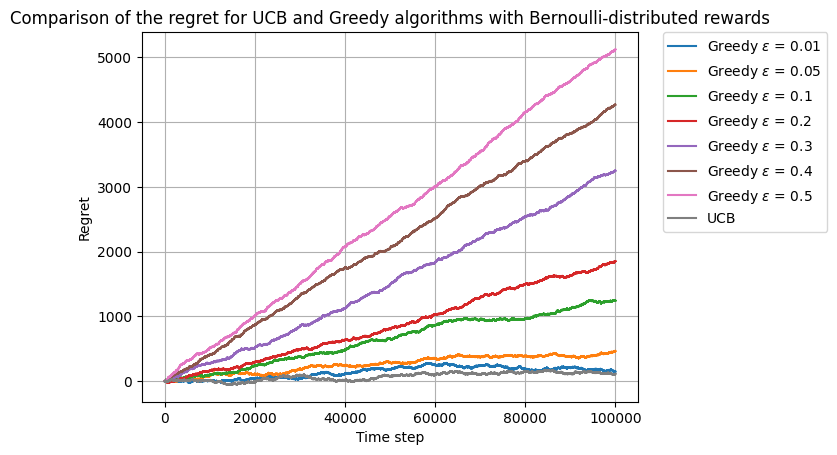

In [18]:
n_steps = 100000

eps_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for eps in eps_values:
    model = MAB()
    agent = Greedy(model, eps=eps, init_value=0, init_count=0)
    rewards = agent.get_episode(n_steps=n_steps)
    regret = max(model.params) * np.arange(len(rewards)) - np.cumsum(rewards)
    plt.plot(regret, label='Greedy $\epsilon$ = {}'.format(eps))

model = MAB()
agent_ucb = UCB(model)
rewards_ucb = agent_ucb.get_episode(n_steps=n_steps)
regret_ucb = max(model.params) * np.arange(len(rewards_ucb)) - np.cumsum(rewards_ucb)

plt.plot(regret_ucb, label='UCB')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Comparison of the regret for UCB and Greedy algorithms with Bernoulli-distributed rewards')
plt.grid()
plt.show()

### Uniform-distributed rewards

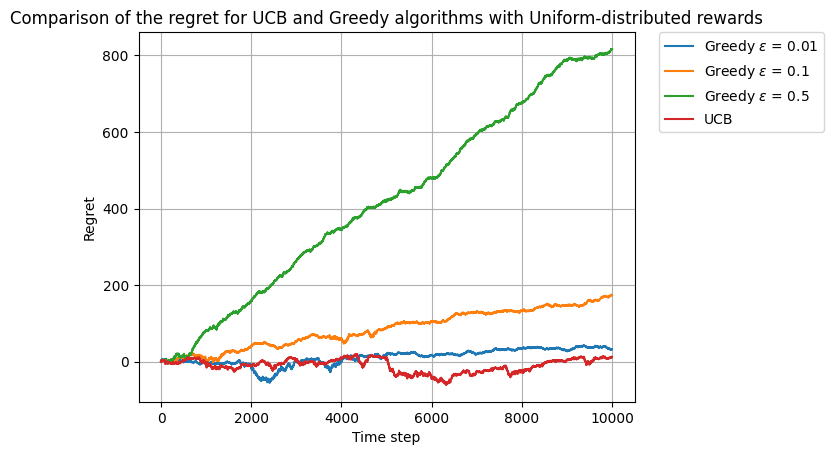

In [19]:
n_steps = 10000

eps_values = [0.01, 0.1, 0.5]
for eps in eps_values:
    model = MAB(distribution='uniform', params=[(-1, 1), (0, 1), (-1, 2)])
    agent = Greedy(model, eps=eps, init_value=0, init_count=0)
    rewards = agent.get_episode(n_steps=n_steps)
    regret = max([(uniform_range[0] + uniform_range[1])/2 for uniform_range in model.params]) * np.arange(len(rewards)) - np.cumsum(rewards)
    plt.plot(regret, label='Greedy $\epsilon$ = {}'.format(eps))

model = MAB(distribution='uniform', params=[(-1, 1), (0, 1), (-1, 2)])
agent_ucb = UCB(model)
rewards_ucb = agent_ucb.get_episode(n_steps=n_steps)
regret_ucb = max([(uniform_range[0] + uniform_range[1])/2 for uniform_range in model.params]) * np.arange(len(rewards_ucb)) - np.cumsum(rewards_ucb)

plt.plot(regret_ucb, label='UCB')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Comparison of the regret for UCB and Greedy algorithms with Uniform-distributed rewards')
plt.grid()
plt.show()

### Gaussian-distributed rewards

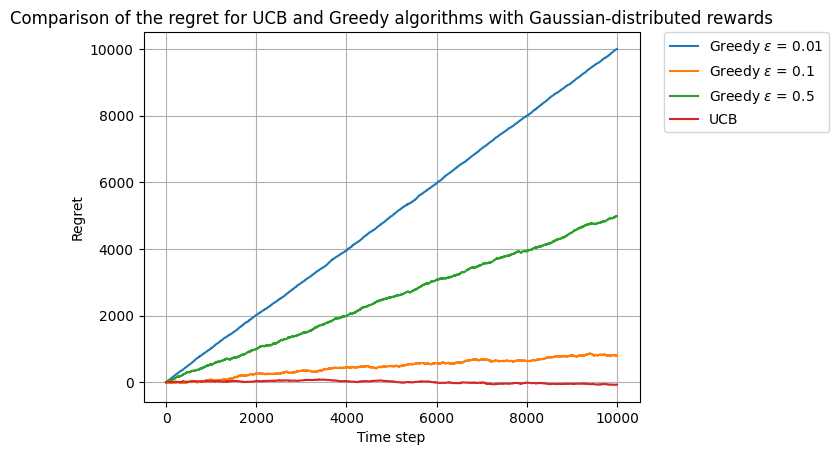

In [20]:
n_steps = 10000

eps_values = [0.01, 0.1, 0.5]
for eps in eps_values:
    model = MAB(distribution='gaussian', params=[(0, 1), (1, 2), (-1, 1)])
    agent = Greedy(model, eps=eps, init_value=0, init_count=0)
    rewards = agent.get_episode(n_steps=n_steps)
    regret = max([gaussian_params[0] for gaussian_params in model.params]) * np.arange(len(rewards)) - np.cumsum(rewards)
    plt.plot(regret, label='Greedy $\epsilon$ = {}'.format(eps))

model = MAB(distribution='gaussian', params=[(-1, 1), (0, 1), (-1, 2)])
agent_ucb = UCB(model)
rewards_ucb = agent_ucb.get_episode(n_steps=n_steps)
regret_ucb = max([gaussian_params[0] for gaussian_params in model.params]) * np.arange(len(rewards_ucb)) - np.cumsum(rewards_ucb)

plt.plot(regret_ucb, label='UCB')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Comparison of the regret for UCB and Greedy algorithms with Gaussian-distributed rewards')
plt.grid()
plt.show()

## Thompson sampling

Finally, we consider Thompson Sampling, where the mean rewards are considered as random and sampled according to the posterior distribution (Bayesian algorithm).

In [21]:
class TS(Bandit):
    """Bandit algorithm with Thompson sampling. 

    Parameters
    ----------
    model : object of class MAB
        The model.
    """
    
    def __init__(self, model):
        super(TS, self).__init__(model) 
        self.distribution = model.distribution
            
    def get_action(self, state=None):
        """Get action with TS policy."""
        values = np.array(self.values)
        counts = np.array(self.counts)
        if self.distribution == 'bernoulli':
            n_ones = values * counts
            n_zeros = counts - n_ones
            samples = np.random.beta(n_ones + 1, n_zeros + 1)
        else:
            means = values
            stds = np.sqrt(1 / (counts + 1))
            samples = np.random.normal(means, stds)
        return np.argmax(samples)


### Bernoulli-distributed rewards

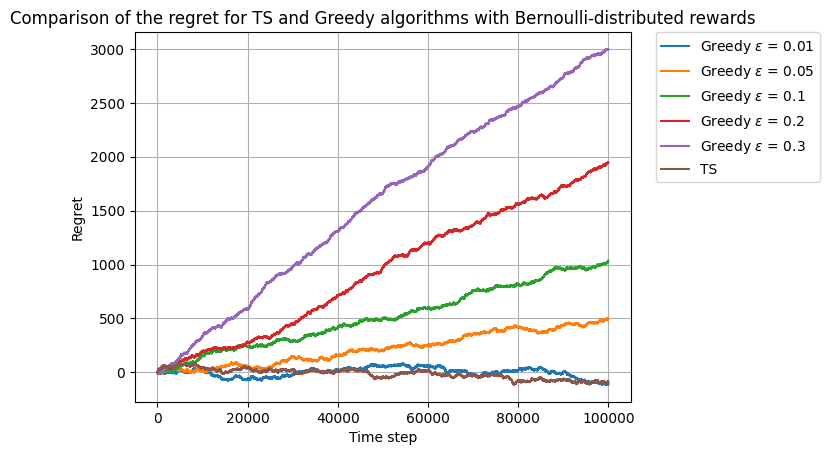

In [22]:
n_steps = 100000

eps_values = [0.01, 0.05, 0.1, 0.2, 0.3]
for eps in eps_values:
    model = MAB()
    agent = Greedy(model, eps=eps, init_value=0, init_count=0)
    rewards = agent.get_episode(n_steps=n_steps)
    regret = max(model.params) * np.arange(len(rewards)) - np.cumsum(rewards)
    plt.plot(regret, label='Greedy $\epsilon$ = {}'.format(eps))

model = MAB()
agent_ts = TS(model)
rewards_ts = agent_ts.get_episode(n_steps=n_steps)
regret_ts = max(model.params) * np.arange(len(rewards_ts)) - np.cumsum(rewards_ts)

plt.plot(regret_ts, label='TS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Comparison of the regret for TS and Greedy algorithms with Bernoulli-distributed rewards')
plt.grid()
plt.show()

### Uniform-distributed rewards

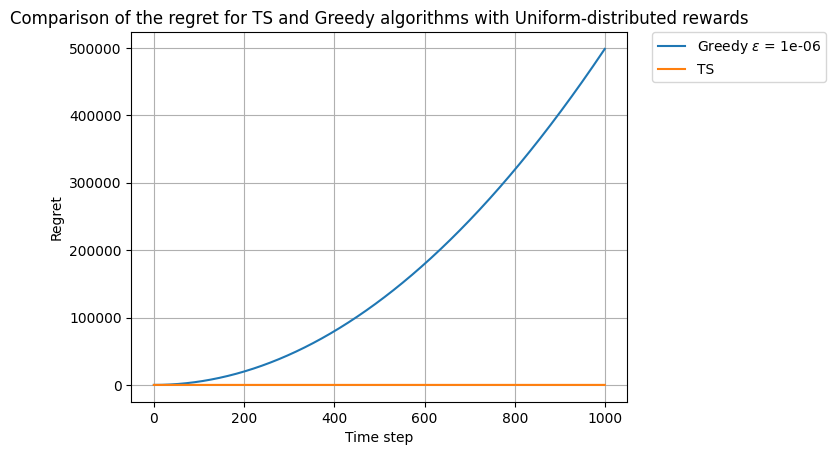

In [23]:
n_steps = 1000

eps_values = [0.000001, ]
for eps in eps_values:
    model = MAB(distribution='uniform', params=[(-1, 1), (0, 1), (-1, 2)])
    agent = Greedy(model, eps=eps, init_value=0, init_count=0)
    rewards = agent.get_episode(n_steps=n_steps)
    regret = max([(uniform_range[0] + uniform_range[1])/2 for uniform_range in model.params]) * np.arange(len(rewards)) * np.arange(len(rewards)) - np.cumsum(rewards)
    plt.plot(regret, label='Greedy $\epsilon$ = {}'.format(eps))

model = MAB(distribution='uniform', params=[(-1, 1), (0, 1), (-1, 2)])
agent_ts = TS(model)
rewards_ts = agent_ts.get_episode(n_steps=n_steps)
regret_ts = max([(uniform_range[0] + uniform_range[1])/2 for uniform_range in model.params]) * np.arange(len(rewards_ts)) - np.cumsum(rewards_ts)

plt.plot(regret_ts, label='TS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Comparison of the regret for TS and Greedy algorithms with Uniform-distributed rewards')
plt.grid()
plt.show()

### Gaussian-distributed rewards

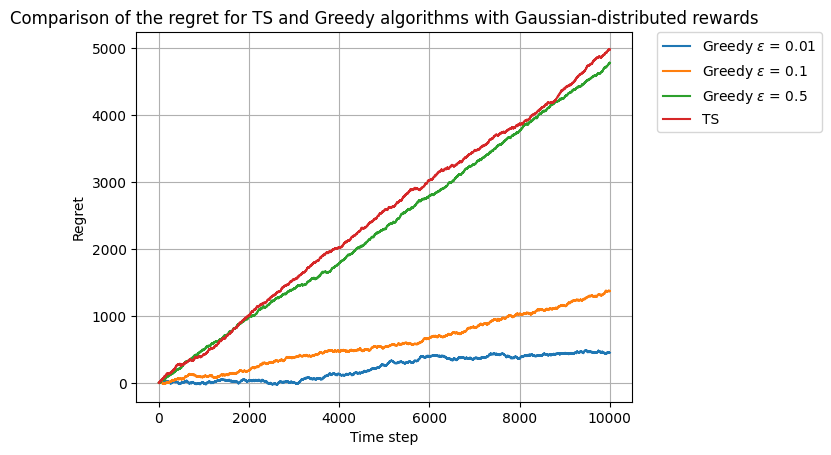

In [24]:
n_steps = 10000

eps_values = [0.01, 0.1, 0.5]
for eps in eps_values:
    model = MAB(distribution='gaussian', params=[(0, 1), (1, 2), (-1, 1)])
    agent = Greedy(model, eps=eps, init_value=0, init_count=0)
    rewards = agent.get_episode(n_steps=n_steps)
    regret = max([gaussian_params[0] for gaussian_params in model.params]) * np.arange(len(rewards)) - np.cumsum(rewards)
    plt.plot(regret, label='Greedy $\epsilon$ = {}'.format(eps))

model = MAB(distribution='gaussian', params=[(0, 1), (1, 2), (-1, 1)])
agent_ts = TS(model)
rewards_ts = agent_ts.get_episode(n_steps=n_steps)
regret_ts = max([(uniform_range[0] + uniform_range[1])/2 for uniform_range in model.params]) * np.arange(len(rewards_ts)) - np.cumsum(rewards_ts)

plt.plot(regret_ts, label='TS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Comparison of the regret for TS and Greedy algorithms with Gaussian-distributed rewards')
plt.grid()
plt.show()